# <font color = darkred>  Neural Networks:</font>
## image processing : Chest_Xray dataset


__________________
### First : import necessory Libraries.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os 

os.environ['KMP_DUPLICATE_LIB_OK']='True'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

from glob import glob

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

________________
### Data preparation

In [4]:

train_normal_path = 'dataset/chest_xray' +'\\'+'train/NORMAL'
train_pneumonia_path = 'dataset/chest_xray' +'\\'+'train/PNEUMONIA'

val_normal_path= 'dataset/chest_xray' +'\\'+'test/NORMAL'
val_pneumonia_path= 'dataset/chest_xray' +'\\'+'train/PNEUMONIA'


In [5]:
TRAIN_PATH = 'dataset/chest_xray/train'
TEST_PATH = 'dataset/chest_xray/test'

In [6]:
train_imgs = glob(TRAIN_PATH+'/*/*.jp*g')
test_imgs = glob(TEST_PATH+'/*/*.jp*g')

In [7]:
train_normal = glob(TRAIN_PATH+'/N*/*.jp*g')
train_pneumonia = glob(TRAIN_PATH+'/P*/*.jp*g')

print('total number of images:' , len(train_imgs))
print('number of images in class(NORMAL):',len(train_normal) )
print('number of images in class(PNEUMONIA):',len(train_pneumonia) )

total number of images: 5232
number of images in class(NORMAL): 1349
number of images in class(PNEUMONIA): 3883


In [8]:
test_normal = glob(TEST_PATH+'/N*/*.jp*g')
test_pneumonia = glob(TEST_PATH+'/P*/*.jp*g')

print('total number of images:' , len(train_imgs))
print('number of images in class(NORMAL):',len(test_normal) )
print('number of images in class(PNEUMONIA):',len(test_pneumonia) )

total number of images: 5232
number of images in class(NORMAL): 234
number of images in class(PNEUMONIA): 390


In [9]:
d1 = pd.DataFrame(train_normal, columns=['image_path'])
d1['label']=0
d2 = pd.DataFrame(train_pneumonia, columns=['image_path'])
d2['label']=1
train_data = d1.append(d2)

C:\Users\Haya\AppData\Local\Temp\ipykernel_52768\1886164820.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = d1.append(d2)


In [10]:
d3 = pd.DataFrame(test_normal, columns=['image_path'])
d3['label']=0
d4 = pd.DataFrame(test_pneumonia, columns=['image_path'])
d4['label']=1
val_data = d3.append(d4)

C:\Users\Haya\AppData\Local\Temp\ipykernel_52768\2409161934.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_data = d3.append(d4)


In [11]:
print("Train Data {}".format(train_data.shape))
print("Validation Data {}".format(val_data.shape))


Train Data (5232, 2)
Validation Data (624, 2)


## Image Visualization:

image size:  (2572, 2476)


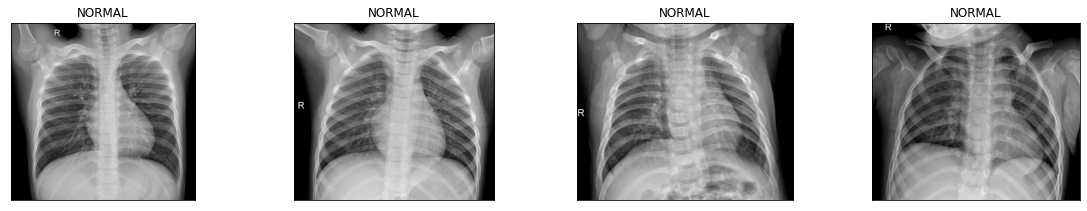

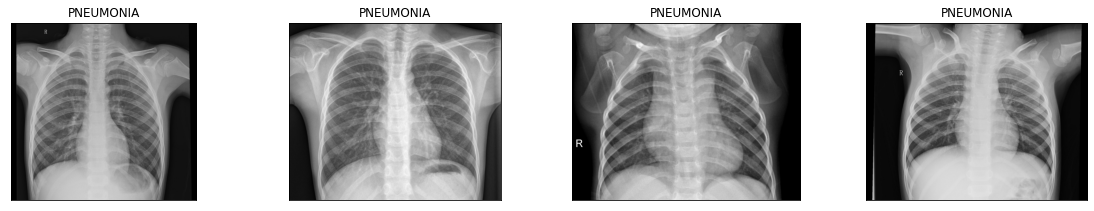

In [12]:
img = image.load_img(train_imgs[0])
print('image size: ' , img.size)
fig = plt.figure(figsize=(20, 15))
for i in range(4):
    fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = image.load_img(train_imgs[i])
    plt.imshow(img)
    plt.title('NORMAL')

fig = plt.figure(figsize=(20, 15))
for i in range(4):
    fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = image.load_img(test_imgs[i])
    plt.imshow(img)
    plt.title('PNEUMONIA')


___________
### Data Preprocessing: 

#### Gray to 3-channels : to fit pre-trained model input

In [13]:
def gray_to_rgb(img):
    return img*np.array([[[1/255.,1/255.,1/255.]]])

In [14]:
datagen_train = ImageDataGenerator(
    zoom_range=0.1, 
    horizontal_flip=False,   
    vertical_flip=False,
    preprocessing_function=gray_to_rgb
        
)  

datagen_valid = ImageDataGenerator(preprocessing_function=gray_to_rgb)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
188928
min:6.0347843827912584e-05,max:0.9720993638038635


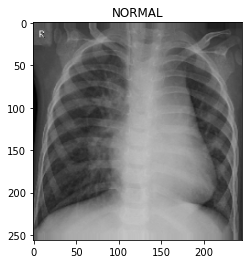

In [15]:
train_it = datagen_train.flow_from_directory(
    TRAIN_PATH,
    target_size=(256, 246),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
)

# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    TEST_PATH,
    target_size=(256, 246),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
)

labels = list(train_it.class_indices.keys())
for x , y in train_it:
    
    print(x[0].size)
    print(f'min:{x[0].min()},max:{x[0].max()}')
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [16]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_lb = to_categorical(train_data['label'], dtype = int)
val_lb = to_categorical(val_data['label'], dtype=int)

train_data = train_data.reset_index().drop(labels='index', axis=1)
y_train = pd.DataFrame(train_lb).add_prefix('label_')

val_data = val_data.reset_index().drop(labels='index', axis=1)
y_val = pd.DataFrame(val_lb).add_prefix('label_')

train_data = pd.concat([train_data, y_train], axis=1)
val_data = pd.concat([val_data, y_val], axis=1)


### Using another Generator from : https://github.com/mohit-keshwani/pneumonia-detection
gives better results

In [17]:
IMG_SHAPE  = 224

train_image_gen = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         brightness_range=[0.2,1.0],
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest')

train_gen = train_image_gen.flow_from_dataframe(train_data,
                                          x_col='image_path',
                                          y_col=[f'label_{x}' for x in np.arange(2)],
                                          class_mode='raw',
                                          batch_size=32,
                                          shuffle=True,
                                          target_size=(IMG_SHAPE,IMG_SHAPE))


val_image_gen = ImageDataGenerator(rescale=1./255)

val_gen = val_image_gen.flow_from_dataframe(val_data,
                                          x_col='image_path',
                                          y_col= [f'label_{x}' for x in np.arange(2)],
                                          class_mode='raw',
                                          batch_size=32,
                                          target_size=(IMG_SHAPE,IMG_SHAPE))

Found 5232 validated image filenames.
Found 624 validated image filenames.


In [24]:

base = DenseNet169(weights = 'imagenet',
                   include_top = False, 
                   input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False

model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

In [19]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), 
                  metrics=['accuracy'])

history = model.fit(train_gen,
                              steps_per_epoch = 160,
                              epochs = 50,
                              validation_data = val_gen)

C:\Users\Haya\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
160/160 [==============================] - 92s 512ms/step - loss: 0.6912 - accuracy: 0.6744 - val_loss: 0.4581 - val_accuracy: 0.8558
Epoch 2/50
160/160 [==============================] - 81s 503ms/step - loss: 0.4078 - accuracy: 0.8472 - val_loss: 0.3091 - val_accuracy: 0.9054
Epoch 3/50
160/160 [==============================] - 82s 513ms/step - loss: 0.3186 - accuracy: 0.8871 - val_loss: 0.2556 - val_accuracy: 0.9199
Epoch 4/50
160/160 [==============================] - 81s 508ms/step - loss: 0.2691 - accuracy: 0.9069 - val_loss: 0.2367 - val_accuracy: 0.9215
Epoch 5/50
160/160 [==============================] - 80s 499ms/step - loss: 0.2412 - accuracy: 0.9144 - val_loss: 0.2280 - val_accuracy: 0.9215
Epoch 6/50
160/160 [==============================] - 80s 498ms/step - loss: 0.2273 - accuracy: 0.9195 - val_loss: 0.2146 - val_accuracy: 0.9295
Epoch 7/50
160/160 [==============================] - 80s 500ms/step - loss: 0.2149 - accuracy: 0.9236 - val_loss: 0.2030 - val_ac

Text(0, 0.5, 'Accuracy')

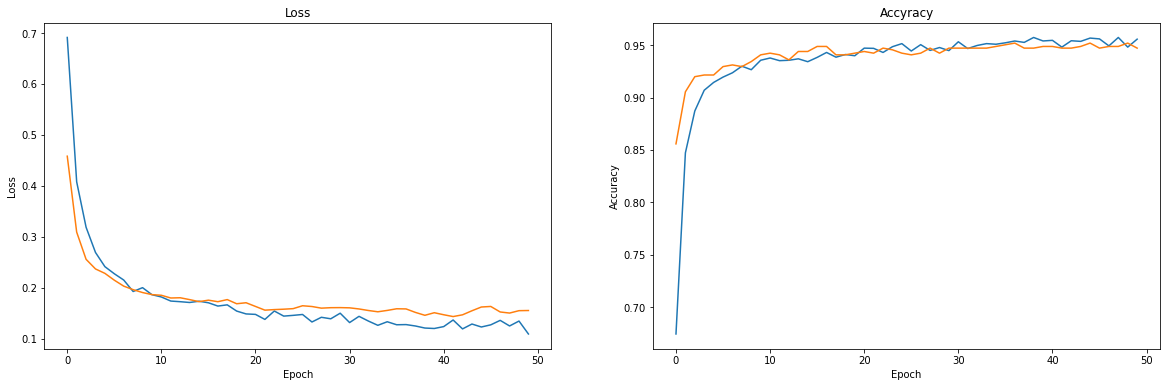

In [20]:
# Plot the training accuracy and loss
fig = plt.figure(figsize=(20,6))
ax = plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accyracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [22]:
print('train accuracy : ' , history.history['accuracy'][-1])
print('test accuracy : ' ,history.history['val_accuracy'][-1])


train accuracy :  0.9556640386581421
test accuracy :  0.9471153616905212
